In [333]:
import pandas as pd
import numpy as np
from scipy import stats,optimize,interpolate,integrate
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import LeastSquares
import math

In [334]:
lotto=pd.read_csv(r'ArchivioLotto.Italia.csv',delimiter=';',names=['date','city','1','2','3','4','5'])
lotto=lotto.replace(lotto['city'][1],'NA')
lotto['dt']=pd.to_datetime(lotto['date'],format="%d/%m/%Y")
lotto89=lotto[lotto['dt'].dt.year<=1989]

In [477]:
np.unique(model.rvs(10000))

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90])

In [500]:
def plot_bar(city_name='all',Y1=1939,Y2=2022,show=True):
    if city_name!='all':
        lc=lotto[(lotto.city==city_name)&(lotto['dt'].dt.year<=Y2)&(lotto['dt'].dt.year>=Y1)].copy()
    else:
        lc=lotto[(lotto['dt'].dt.year<=Y2)&(lotto['dt'].dt.year>=Y1)].copy()
        city_name='Totale'
    SC=pd.Series(lc[['1','2','3','4','5']].squeeze().values.ravel())
    cs=SC.value_counts().sort_index()
    if show:
        cs.plot(kind='bar',figsize=(16,9),title='Conteggio estrazioni dal {} al {}, {}'.format(Y1,Y2,city_name))
    return cs
def chi2_test(counts_lotto,show=False):
    counts_lotto
    unif_counts=pd.Series( dict((i,model.pmf(i)*counts_lotto.sum()) for i in range(1,91)) )
    testchi2=pd.DataFrame( dict( exp=unif_counts,obs=counts_lotto ) )
    testchi2['res']=testchi2['obs']-testchi2['exp']
    testchi2['res2']=testchi2['res']**2
    testchi2['res2_norm']=testchi2['res2']/testchi2['exp']
    chi2=((unif_counts-counts_lotto)**2/unif_counts).sum()
    chi2
    dof=90-1
    p2=stats.chi2.sf(chi2,dof)
    if show:
        print('chi2/dof: {:.2f}/{:.2f}'.format(chi2,dof))
        print('p value: ', p2)
        print('Zσ = {:.2f}σ'.format(-stats.norm.ppf(p2)))
        print(testchi2)
    return pd.DataFrame(dict(chi2=chi2,dof=dof,p=p2,Z=-stats.norm.ppf(p2)),index=[0])

In [504]:
sus=plot_bar(Y1=1980,Y2=2000,show=False)
chi2_test(sus)

,chi2,dof,p,Z
0,127.301313,89,0.004835,2.587383


In [336]:
sample_lotto=pd.Series(lotto89[['1','2','3','4','5']].squeeze().values.ravel())
s1=sample_lotto.values
counts_lotto=sample_lotto.value_counts().sort_index()
lotto_pct=counts_lotto/counts_lotto.sum()
lotto_cdf=lotto_pct.cumsum()

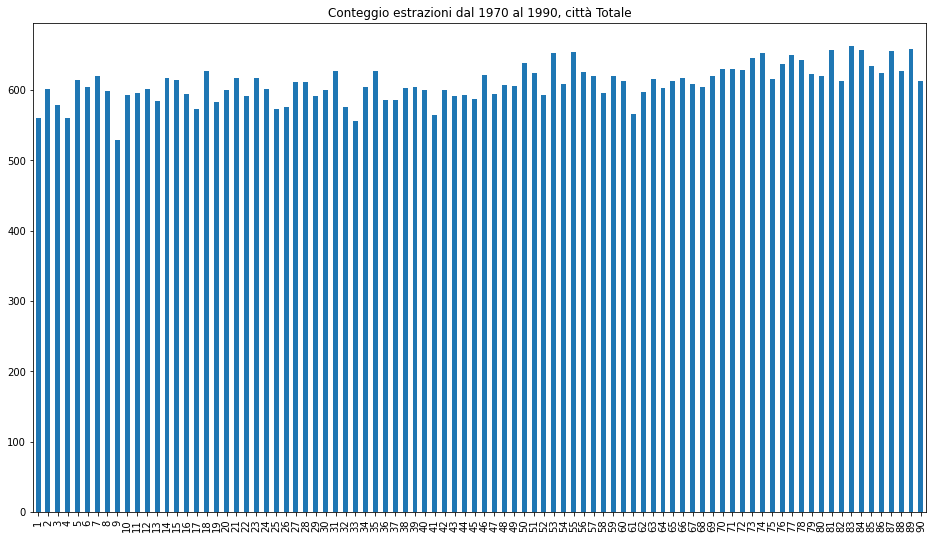

In [342]:
cont=plot_bar(Y1=1970,Y2=1990)

## Analisi condotta con test di Kolmogorov-Smirnov e metodo Monte Carlo
Prima procedura per verificare l'ipotesi nulla $H_0$ che i valori si distribuiscano uniformemente.

In [469]:
model=stats.randint(low=1,high=91,loc=0)
true_cdf=lambda x: stats.randint.cdf(x,low=1,high=91,loc=0)
def my_cdf(x):
    return len(s1[s1<=x])/len(s1)

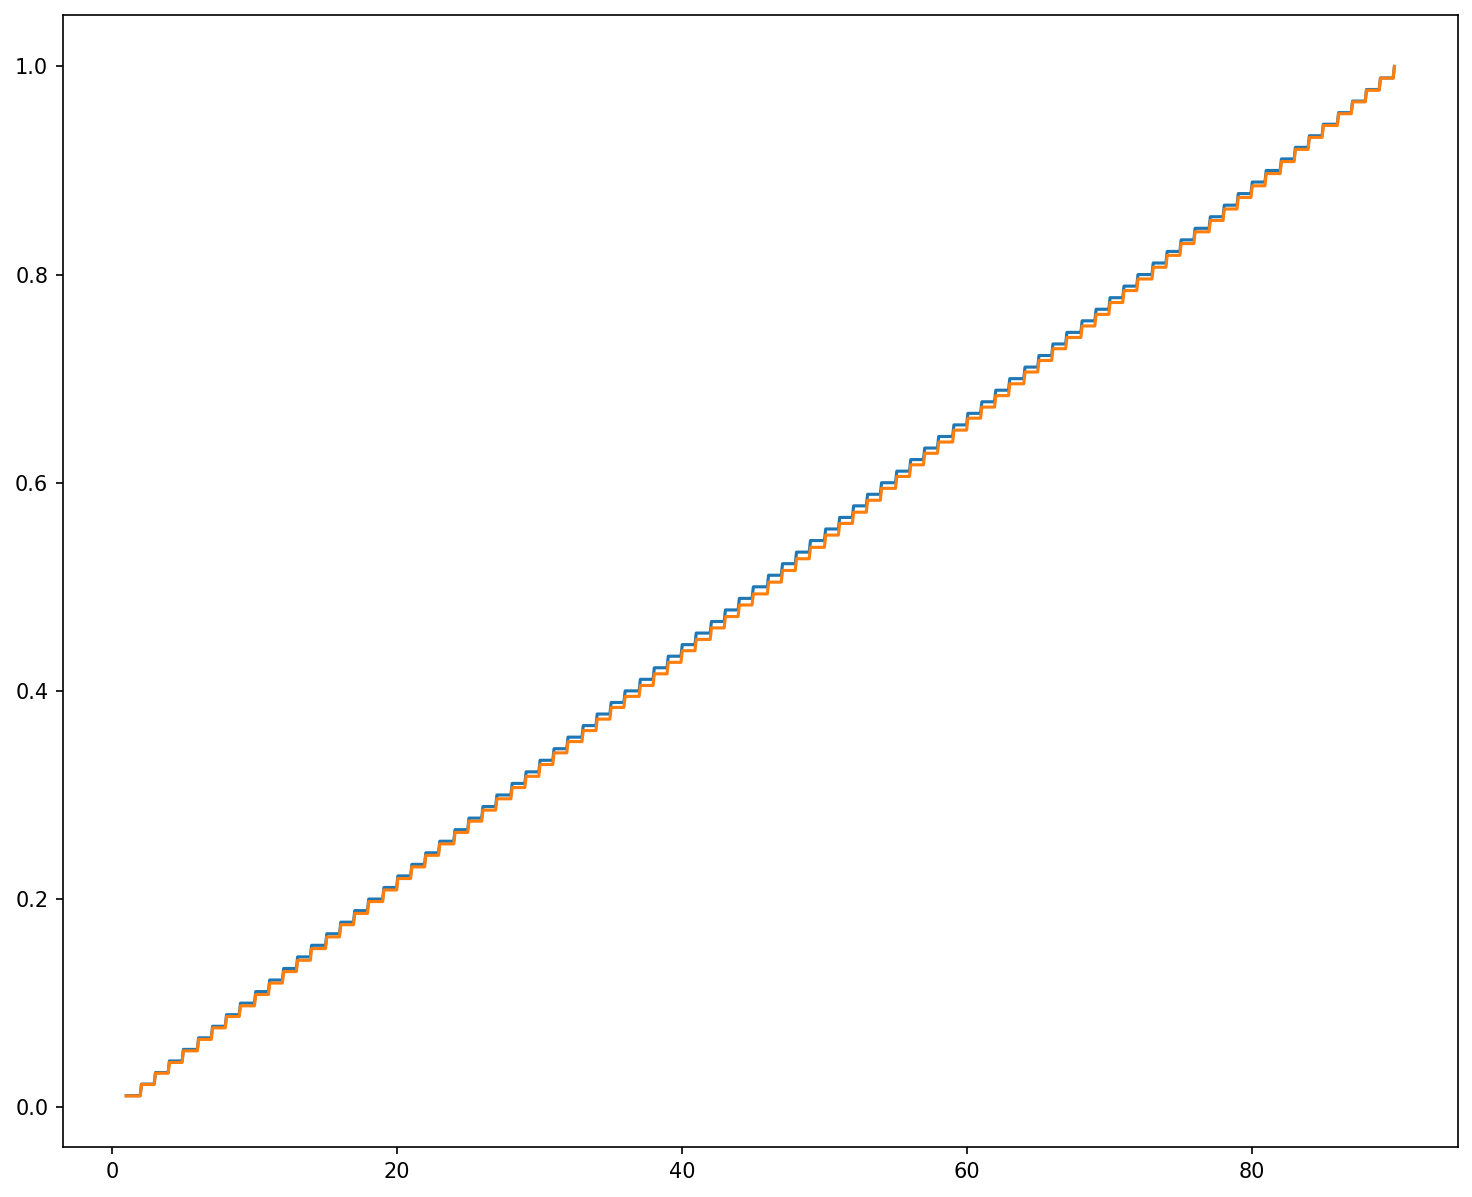

In [7]:
plt.figure(figsize=(12,10),dpi=150)
x0=np.linspace(1,90,1000)
plt.plot(x0,true_cdf(x0))
plt.plot(x0,[my_cdf(p) for p in x0])
plt.show()

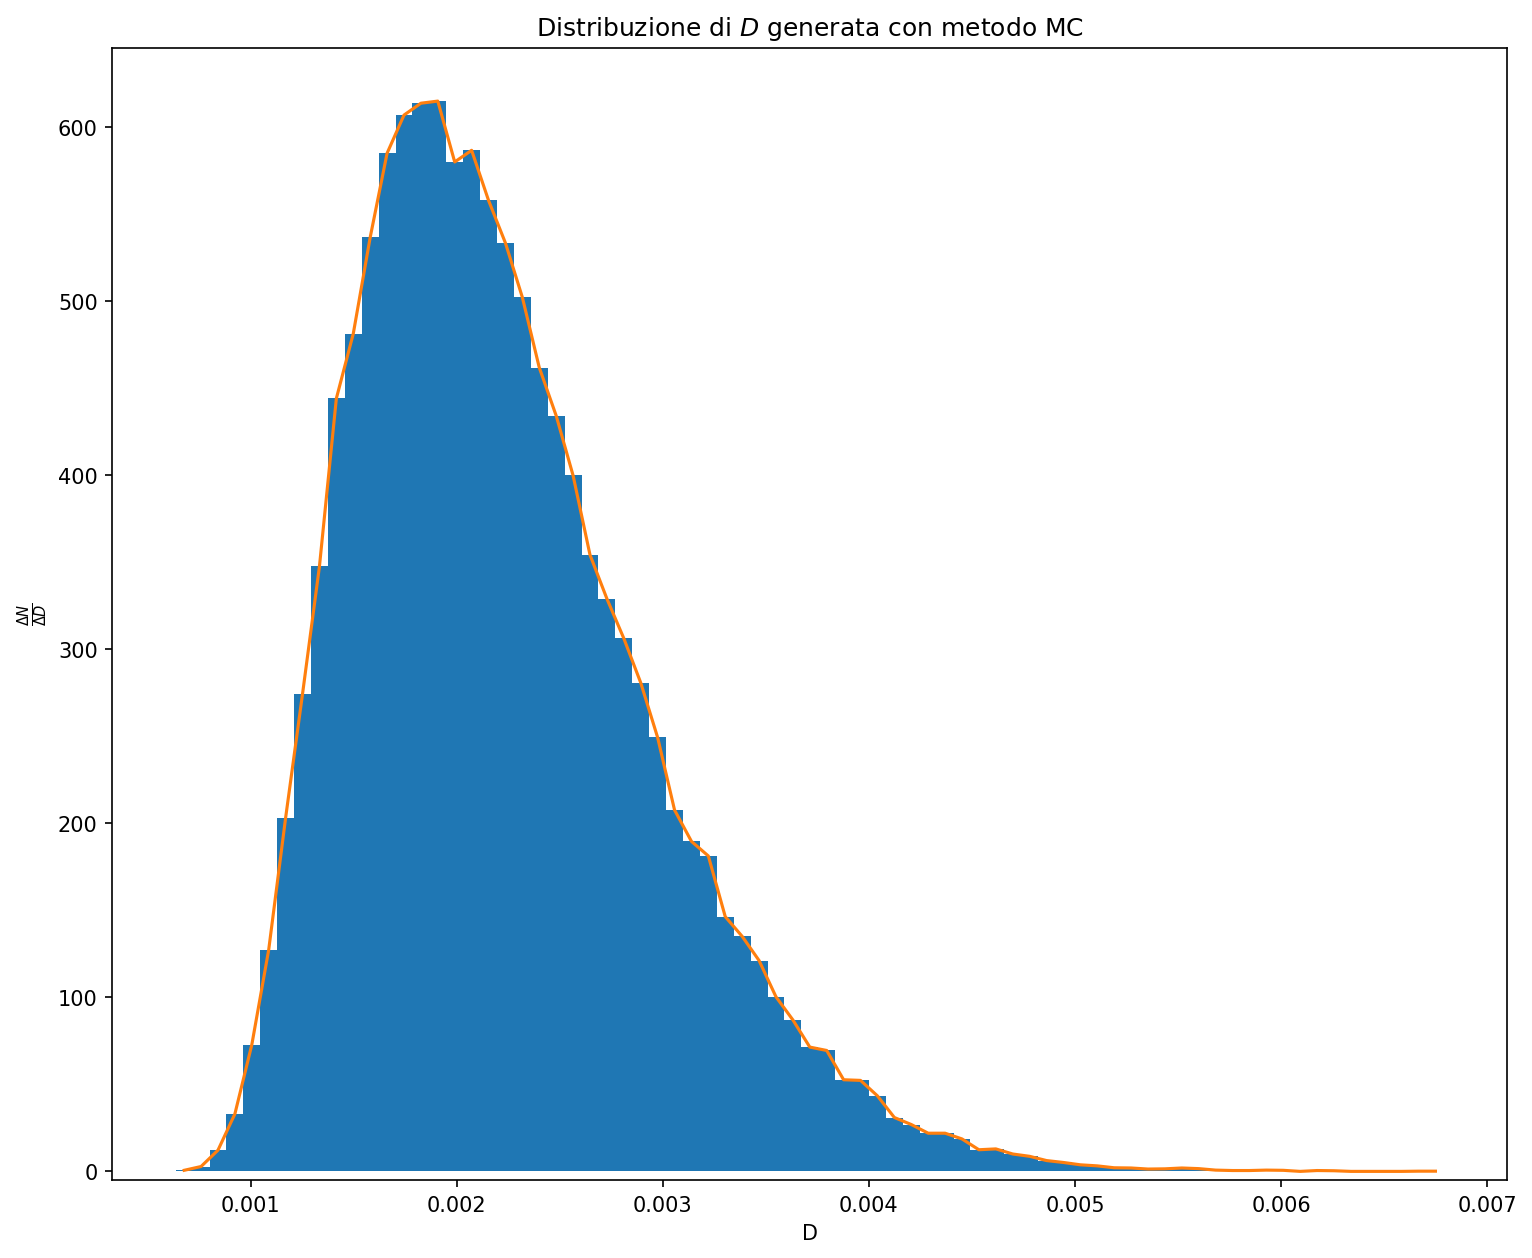

In [10]:
N,n_samp=100000,len(s1)
nbins=75
Ds=np.empty(N)
true_cum=true_cdf(np.array(range(1,91)))
for n in range(N):
    samp_n=model.rvs(n_samp)
    numbers=np.array(range(1,91))
    samp_n_cum=np.array([len(samp_n[samp_n==num])/n_samp for num in numbers]).cumsum()
    D=abs(samp_n_cum-true_cum).max()
    Ds[n]=D
plt.figure(figsize=(12,10),dpi=150)
freqs,bins,patches=plt.hist(Ds,nbins,density=True)
cent_vals=bins[:-1]+np.diff(bins)/2
plt.plot(cent_vals,freqs)
plt.title(r'Distribuzione di $D$ generata con metodo MC')
plt.xlabel('D')
plt.ylabel(r'$\frac{\Delta N}{\Delta D}$')
plt.ylim(-5)
plt.show()

Dmodel=interpolate.interp1d(cent_vals,freqs)

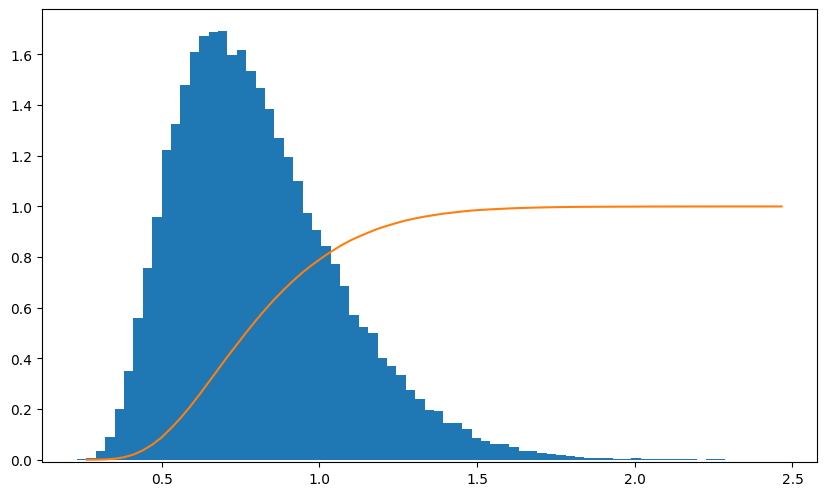

In [278]:
fig, ax = plt.subplots(figsize=(10,6), dpi=100)
data_yraw,data_xraw,ptchs=ax.hist(Ds*np.sqrt(n_samp),nbins,density=True)
data_x=data_xraw[:-1]+np.diff(data_xraw)
data_y=(data_yraw*np.diff(data_xraw)).cumsum()
plt.plot(data_x,data_y)
plt.ylim(-0.01)
plt.show()

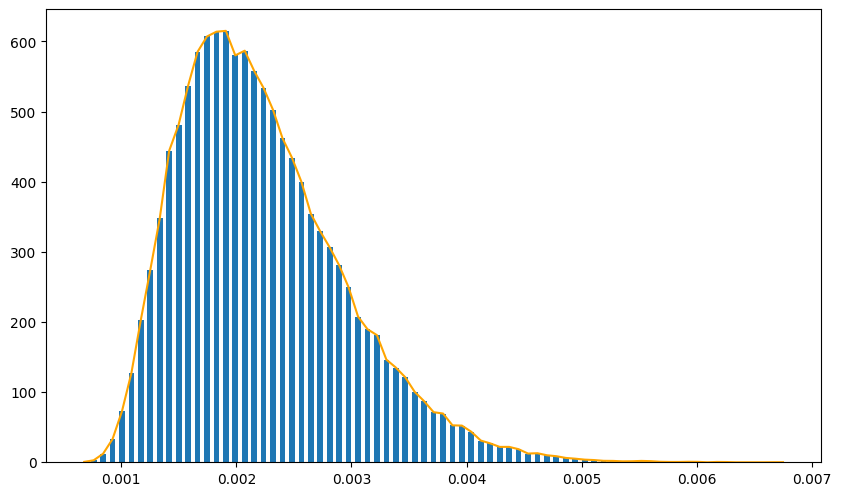

In [48]:
fig, ax = plt.subplots(figsize=(10,6), dpi=100)
ax.bar(cent_vals,freqs,width=0.00005)
ax.plot(cent_vals,freqs,color='orange')
plt.show()

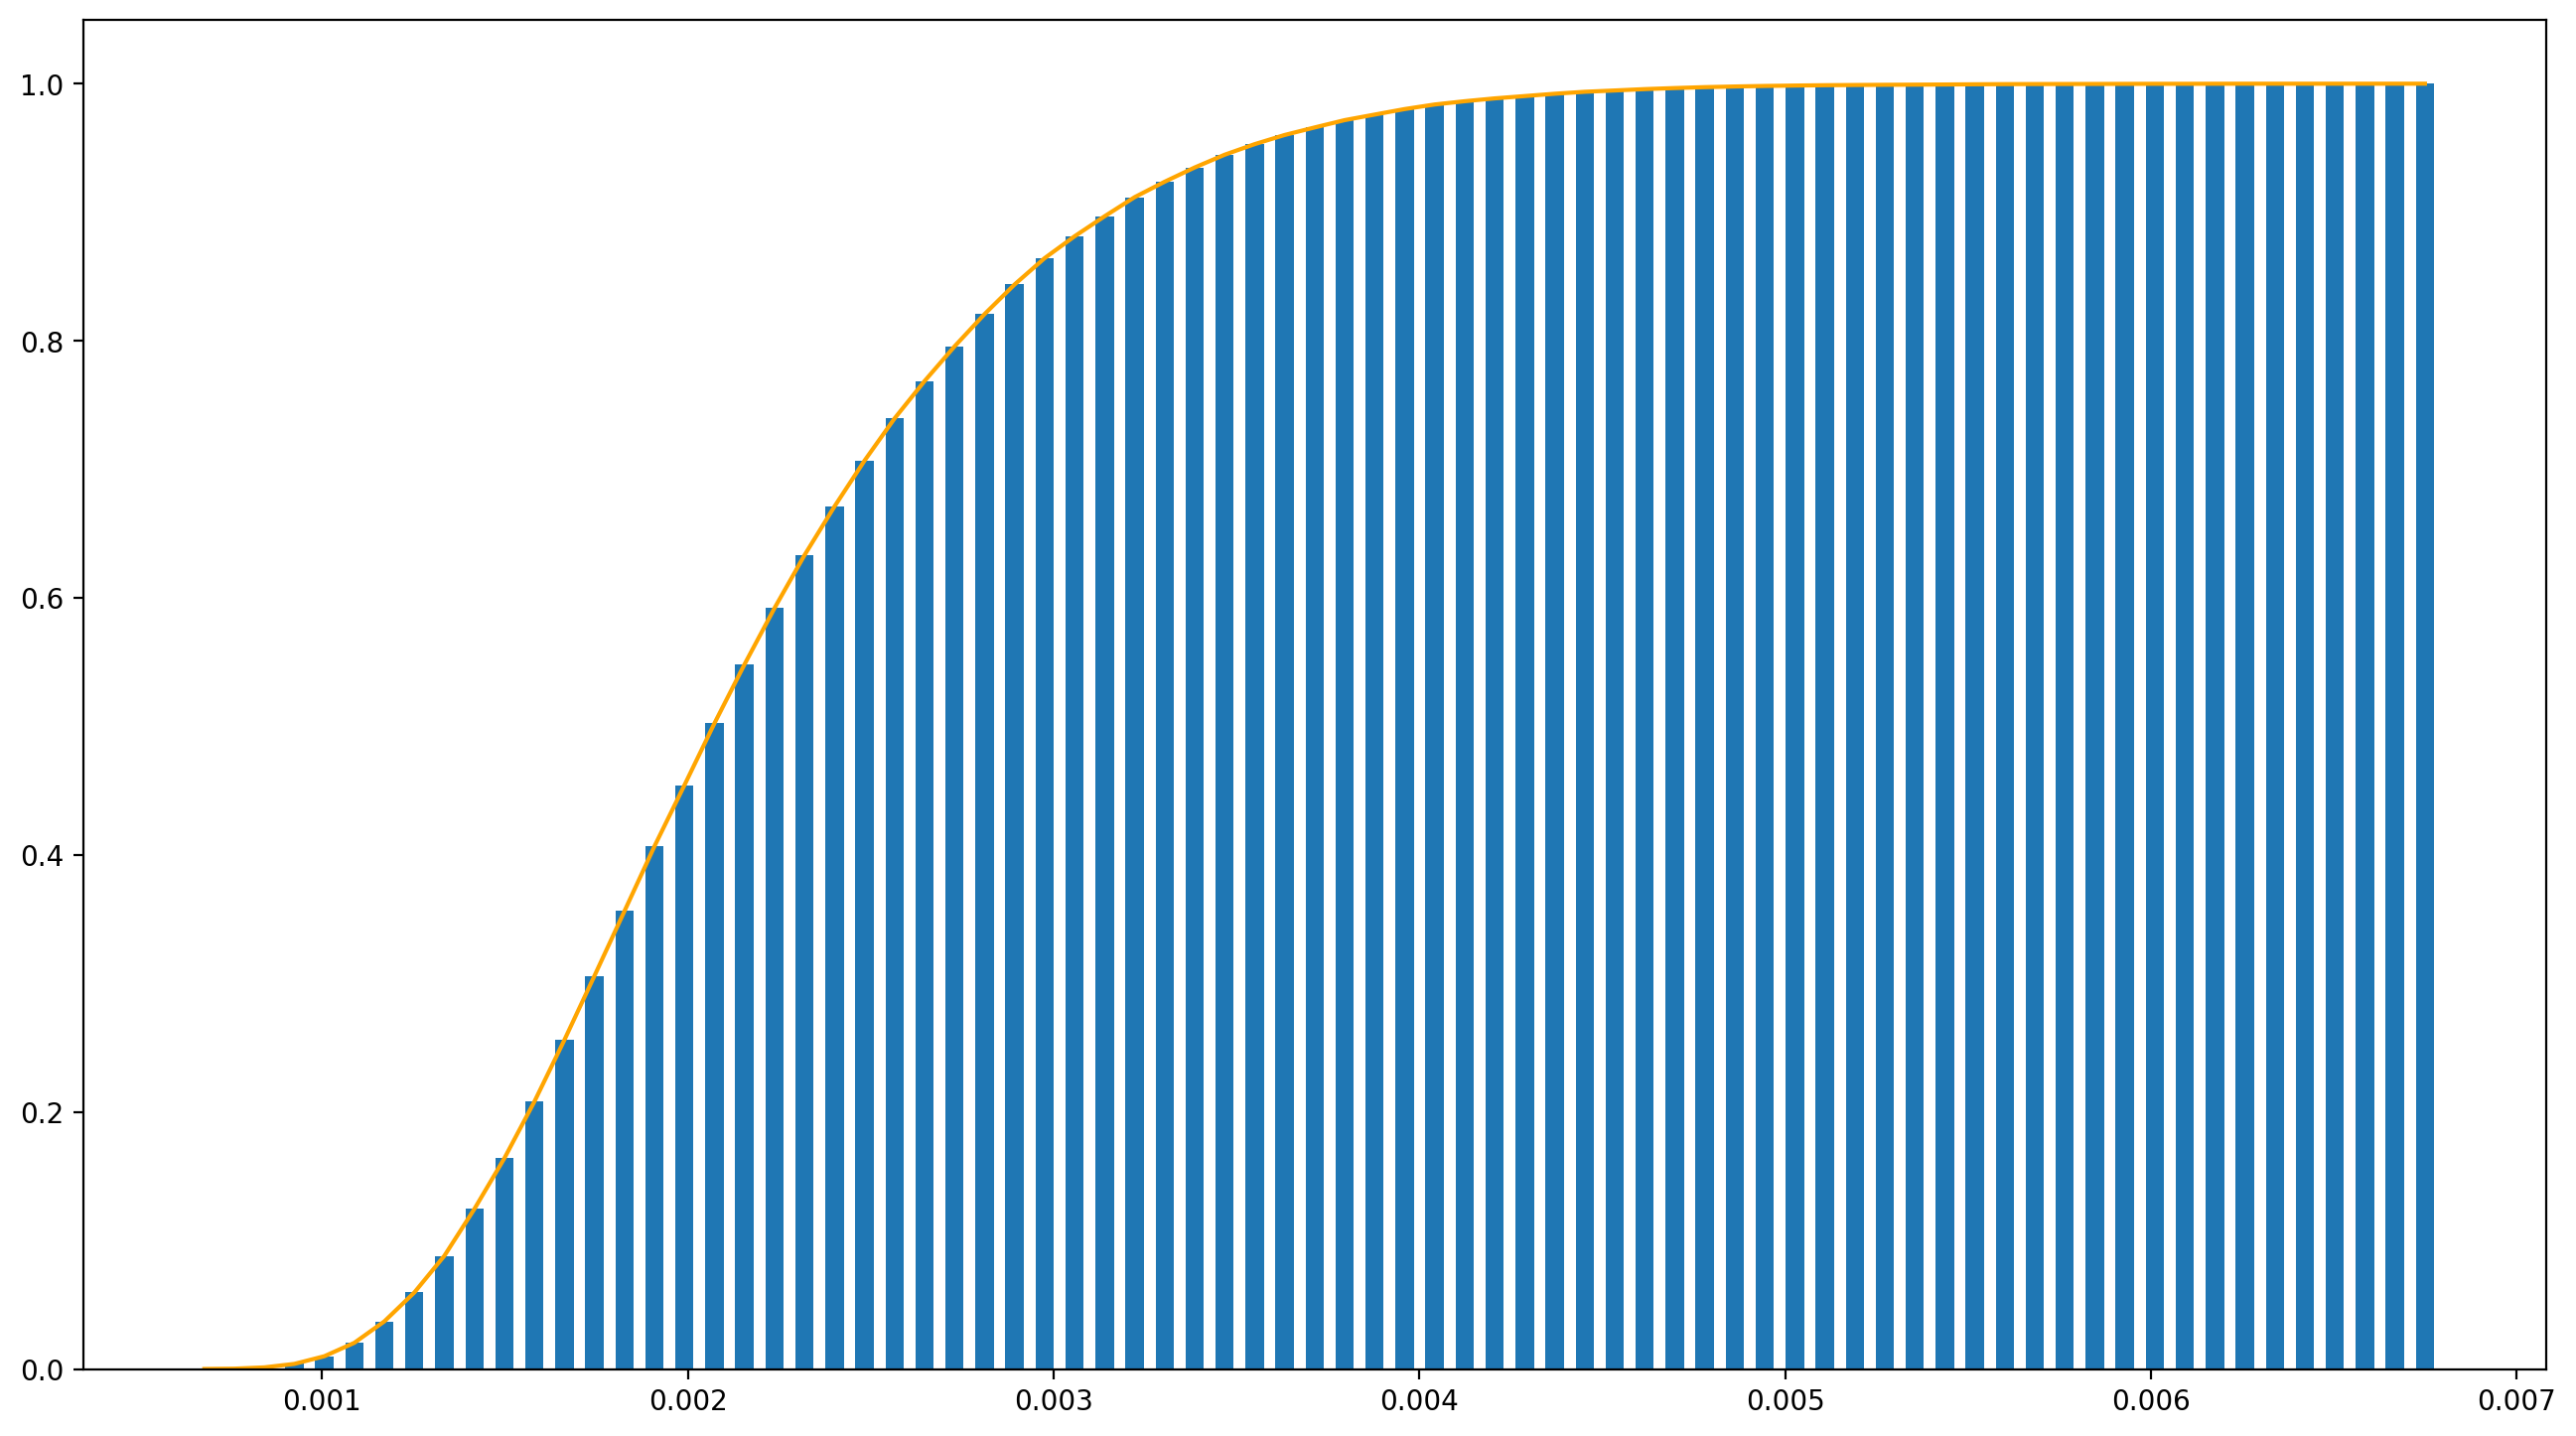

In [55]:
fig, ax = plt.subplots(figsize=(16,9), dpi=200)
#fit_ys = poly_c(cent_vals, *par)
ax.bar(cent_vals,(freqs*np.diff(bins)).cumsum(),width=0.00005)
ax.plot(cent_vals,(freqs*np.diff(bins)).cumsum(),color='orange')
#ax.plot(cent_vals, fit_ys, label='fit, $\sum_{i=1}^8 a_i T_i(x)$')
plt.show()
CUMMODEL=(freqs*np.diff(bins)).cumsum()
CUM=interpolate.interp1d(cent_vals,CUMMODEL)

In [458]:
CUM(cent_vals)

array([5.0000e-05, 2.8000e-04, 1.2800e-03, 3.9900e-03, 9.9600e-03,
       2.0410e-02, 3.7080e-02, 5.9590e-02, 8.8110e-02, 1.2455e-01,
       1.6404e-01, 2.0807e-01, 2.5607e-01, 3.0587e-01, 3.5623e-01,
       4.0669e-01, 4.5428e-01, 5.0242e-01, 5.4820e-01, 5.9197e-01,
       6.3318e-01, 6.7108e-01, 7.0671e-01, 7.3952e-01, 7.6859e-01,
       7.9559e-01, 8.2072e-01, 8.4376e-01, 8.6422e-01, 8.8126e-01,
       8.9682e-01, 9.1169e-01, 9.2370e-01, 9.3478e-01, 9.4472e-01,
       9.5295e-01, 9.6009e-01, 9.6595e-01, 9.7165e-01, 9.7597e-01,
       9.8026e-01, 9.8382e-01, 9.8636e-01, 9.8857e-01, 9.9037e-01,
       9.9217e-01, 9.9370e-01, 9.9472e-01, 9.9578e-01, 9.9660e-01,
       9.9731e-01, 9.9782e-01, 9.9824e-01, 9.9855e-01, 9.9881e-01,
       9.9898e-01, 9.9914e-01, 9.9925e-01, 9.9937e-01, 9.9953e-01,
       9.9966e-01, 9.9972e-01, 9.9976e-01, 9.9980e-01, 9.9986e-01,
       9.9991e-01, 9.9991e-01, 9.9995e-01, 9.9998e-01, 9.9998e-01,
       9.9998e-01, 9.9998e-01, 9.9998e-01, 9.9999e-01, 1.0000e

In [271]:
def FUNC(x,par):
    s=1
    for i in np.arange(0,len(par),2):
        s-=par[i]*np.exp(par[i+1]**2*x**2)
    return s
least_squares = LeastSquares(data_x, data_y, np.ones_like(data_x)*0.1, FUNC)
m = Minuit(least_squares, (1,1,-1,2))

In [272]:
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1400 (chi2/ndof = 19.7)    │              Nfcn = 472              │
│ EDM = 2.41e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │     0     │  1.4e-9   │            │            │         │         │       │
│ 1 │ x1   │1.876795562902│0.000000000005│            │            │         │         │       │
│ 2 │ x2   │    -0     │  0.4e-9   │            │            │         │         │       │
│ 3 │ x3   │1.933345056973│0.000000000020│            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────┐
│    │        x0        x1        x2        x3 │
├────┼─────────────────────────────────────────┤
│ x0 │  1.96e-18  6.48e-21 -5.37e-19  2.82e-20 │
│ x1 │  6.48e-21  2.15e-23 -1.78e-21  9.36e-23 │
│ x2 │ -5.37e-19 -1.78e-21  1.47e-19 -7.75e-21 │
│ x3 │  2.82e-20  9.36e-23 -7.75e-21  4.08e-22 │
└────┴─────────────────────────────────────────┘

In [273]:
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1400 (chi2/ndof = 19.7)    │              Nfcn = 499              │
│ EDM = 5.86e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │     0     │  0.4e-9   │            │            │         │         │       │
│ 1 │ x1   │     2     │    12     │            │            │         │         │       │
│ 2 │ x2   │    -0     │ 0.012e-9  │            │            │         │         │       │
│ 3 │ x3   │    1.9    │    1.2    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────┐
│    │        x0        x1        x2        x3 │
├────┼─────────────────────────────────────────┤
│ x0 │  1.76e-19 -4.97e-09  2.18e-21  -2.3e-10 │
│ x1 │ -4.97e-09       142 -6.97e-11      7.34 │
│ x2 │  2.18e-21 -6.97e-11  1.54e-22 -3.41e-12 │
│ x3 │  -2.3e-10      7.34 -3.41e-12       1.5 │
└────┴─────────────────────────────────────────┘

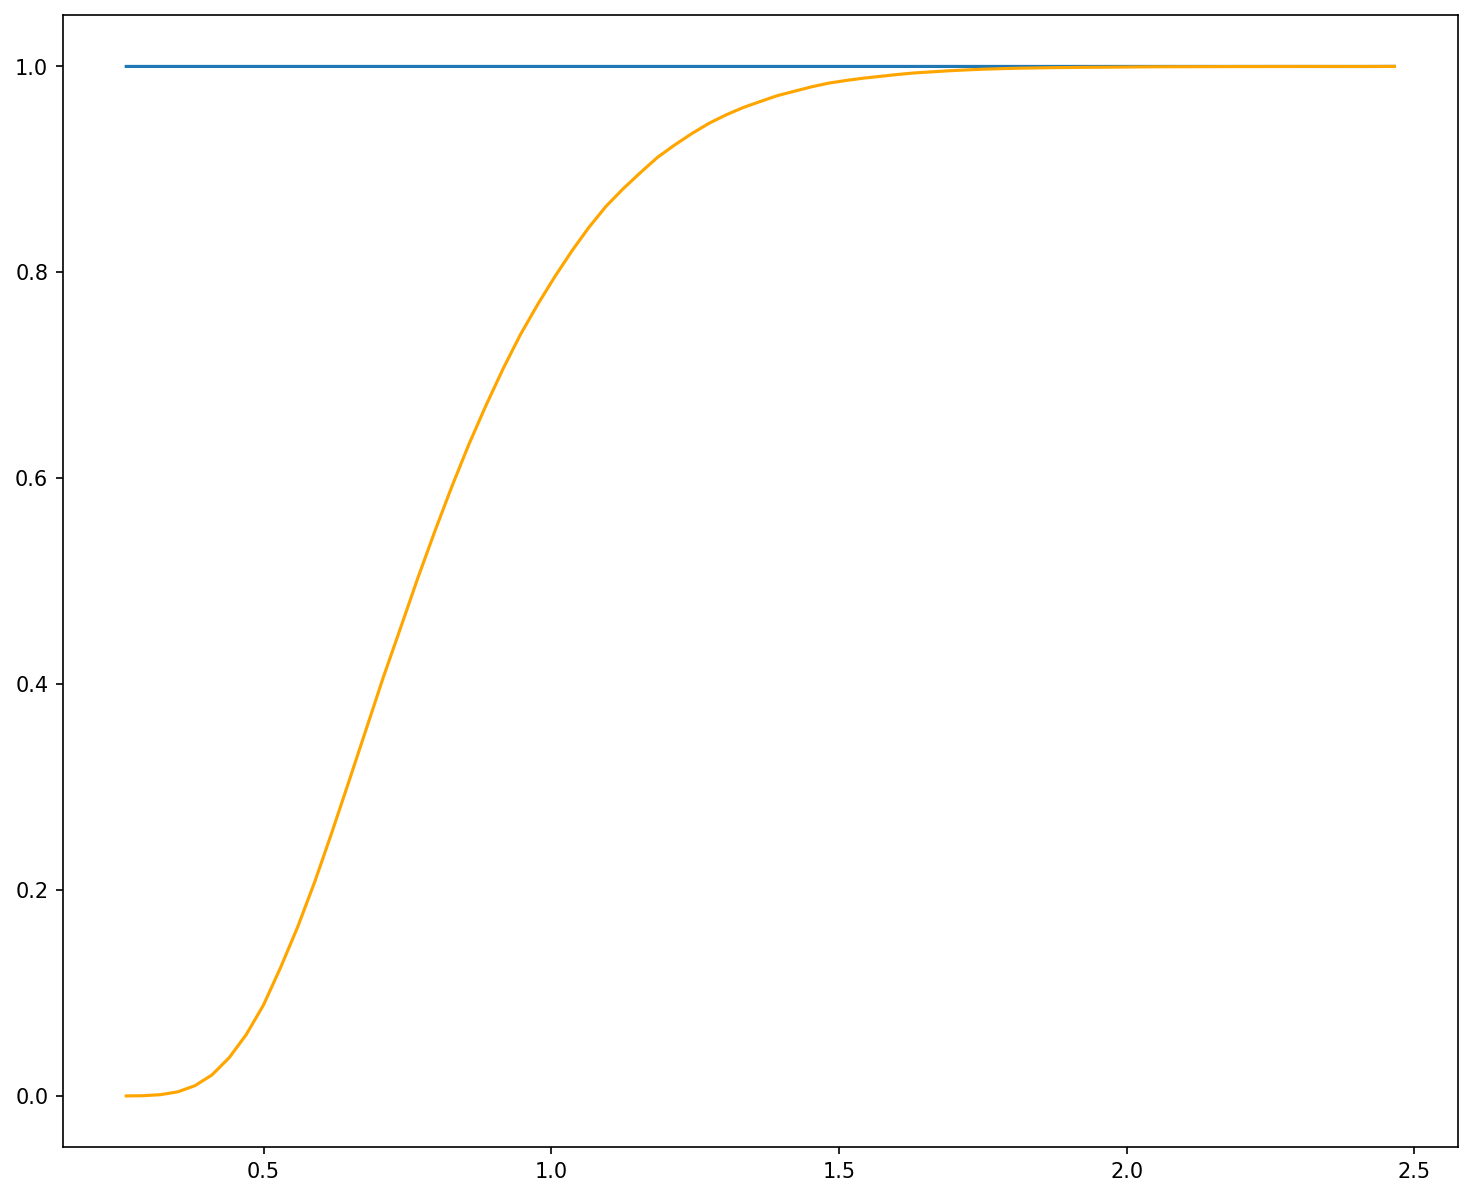

In [274]:
plt.figure(figsize=(12,10),dpi=150)
plt.plot(data_x,FUNC(data_x,m.values))
plt.plot(data_x,data_y,color='orange')
plt.show()

In [457]:
def pval(D_hat):
    if (D_hat<=cent_vals.max())&(D_hat>=cent_vals.min()):
        return integrate.quad(Dmodel,D_hat,cent_vals.max())
    else:
        raise Exception('Value not included in interp. range') 
d=lambda x: abs(true_cdf(x)-my_cdf(x))
numbers=np.array(range(1,91))
dnumbers=abs(true_cdf(numbers)-np.array([my_cdf(n) for n in numbers]))
Dhat=dnumbers.max()
#Dhat=d(optimize.fminbound(lambda x: -d(x),1,90))
xD=numbers[dnumbers==Dhat]
#p1=pval(Dhat)[0]
#p1=1-CUM(Dhat)
#print('D observed: ',Dhat)
#print('p value: ', p1)
#print('Zσ = {:.2f}σ'.format(-stats.norm.ppf(p1)))
Dhat,xD

(0.0068213703408789295, array([45]))

Metodo meno efficiente...

In [ ]:
N,n_samp=50000,len(s1)
nbins=75
Ds=np.empty(N)
for n in range(N):
    samp_n=model.rvs(n_samp)
    cdf=lambda x: len(samp_n[samp_n<=x])/n_samp
    d=lambda x: abs(true_cdf(x)-cdf(x))
    D=d(optimize.fminbound(lambda x: -d(x),1,90))
    Ds[n]=D
plt.figure(figsize=(12,10),dpi=150)
freqs,bins,patches=plt.hist(Ds,nbins,density=True)
cent_vals=bins[:-1]+np.diff(bins)/2
plt.plot(cent_vals,freqs)
plt.title(r'Distribuzione di $D$ generata con metodo MC')
plt.xlabel('D')
plt.ylabel(r'$\frac{\Delta N}{\Delta D}$')
plt.ylim(-5)
plt.show()
Dmodel=interpolate.interp1d(cent_vals,freqs)

In [ ]:
def pval(D_hat):
    if (D_hat<=cent_vals.max())&(D_hat>=cent_vals.min()):
        return integrate.quad(Dmodel,D_hat,cent_vals.max())
    else:
        raise Exception('Value not included in interp. range') 
d=lambda x: abs(true_cdf(x)-my_cdf(x))
Dhat=d(optimize.fminbound(lambda x: -d(x),1,90))
p1=pval(Dhat)[0]
plt.figure(figsize=(16,9),dpi=150)
x0=np.lispace(1,90,500)
plt.plot(x0,)
plt.plot(x0,)
plt.title('Confronto cdf attesa e osservata')
plt.show()
print('D observed: ',Dhat)
print('p value: ', p1)
print('Zσ = {:.2f}σ'.format(-stats.norm.ppf(p1)))

In [459]:
stats.kstest(s1,true_cdf)

KstestResult(statistic=0.01793248145199, pvalue=2.8928394402036277e-37)

## Secondo metodo di analisi: test del $\chi^2$

In [279]:
counts_lotto
unif_counts=pd.Series( dict((i,model.pmf(i)*counts_lotto.sum()) for i in range(1,91)) )
testchi2=pd.DataFrame( dict( exp=unif_counts,obs=counts_lotto ) )
testchi2['res']=testchi2['obs']-testchi2['exp']
testchi2['res2']=testchi2['res']**2
testchi2['res2_norm']=testchi2['res2']/testchi2['exp']
print(testchi2)
chi2=((unif_counts-counts_lotto)**2/unif_counts).sum()
chi2
dof=90-1
p2=stats.chi2.sf(chi2,dof)
print('chi2/dof: {:.2f}/{:.2f}'.format(chi2,dof))
print('p value: ', p2)
print('Zσ = {:.2f}σ'.format(-stats.norm.ppf(p2)))

            exp   obs        res         res2  res2_norm
1   1465.166667  1430 -35.166667  1236.694444   0.844064
2   1465.166667  1450 -15.166667   230.027778   0.156998
3   1465.166667  1427 -38.166667  1456.694444   0.994218
4   1465.166667  1367 -98.166667  9636.694444   6.577200
5   1465.166667  1468   2.833333     8.027778   0.005479
..          ...   ...        ...          ...        ...
86  1465.166667  1490  24.833333   616.694444   0.420904
87  1465.166667  1499  33.833333  1144.694444   0.781273
88  1465.166667  1467   1.833333     3.361111   0.002294
89  1465.166667  1538  72.833333  5304.694444   3.620540
90  1465.166667  1490  24.833333   616.694444   0.420904

[90 rows x 5 columns]
chi2/dof: 97.22/89.00
p value:  0.2586578115488193
Zσ = 0.65σ


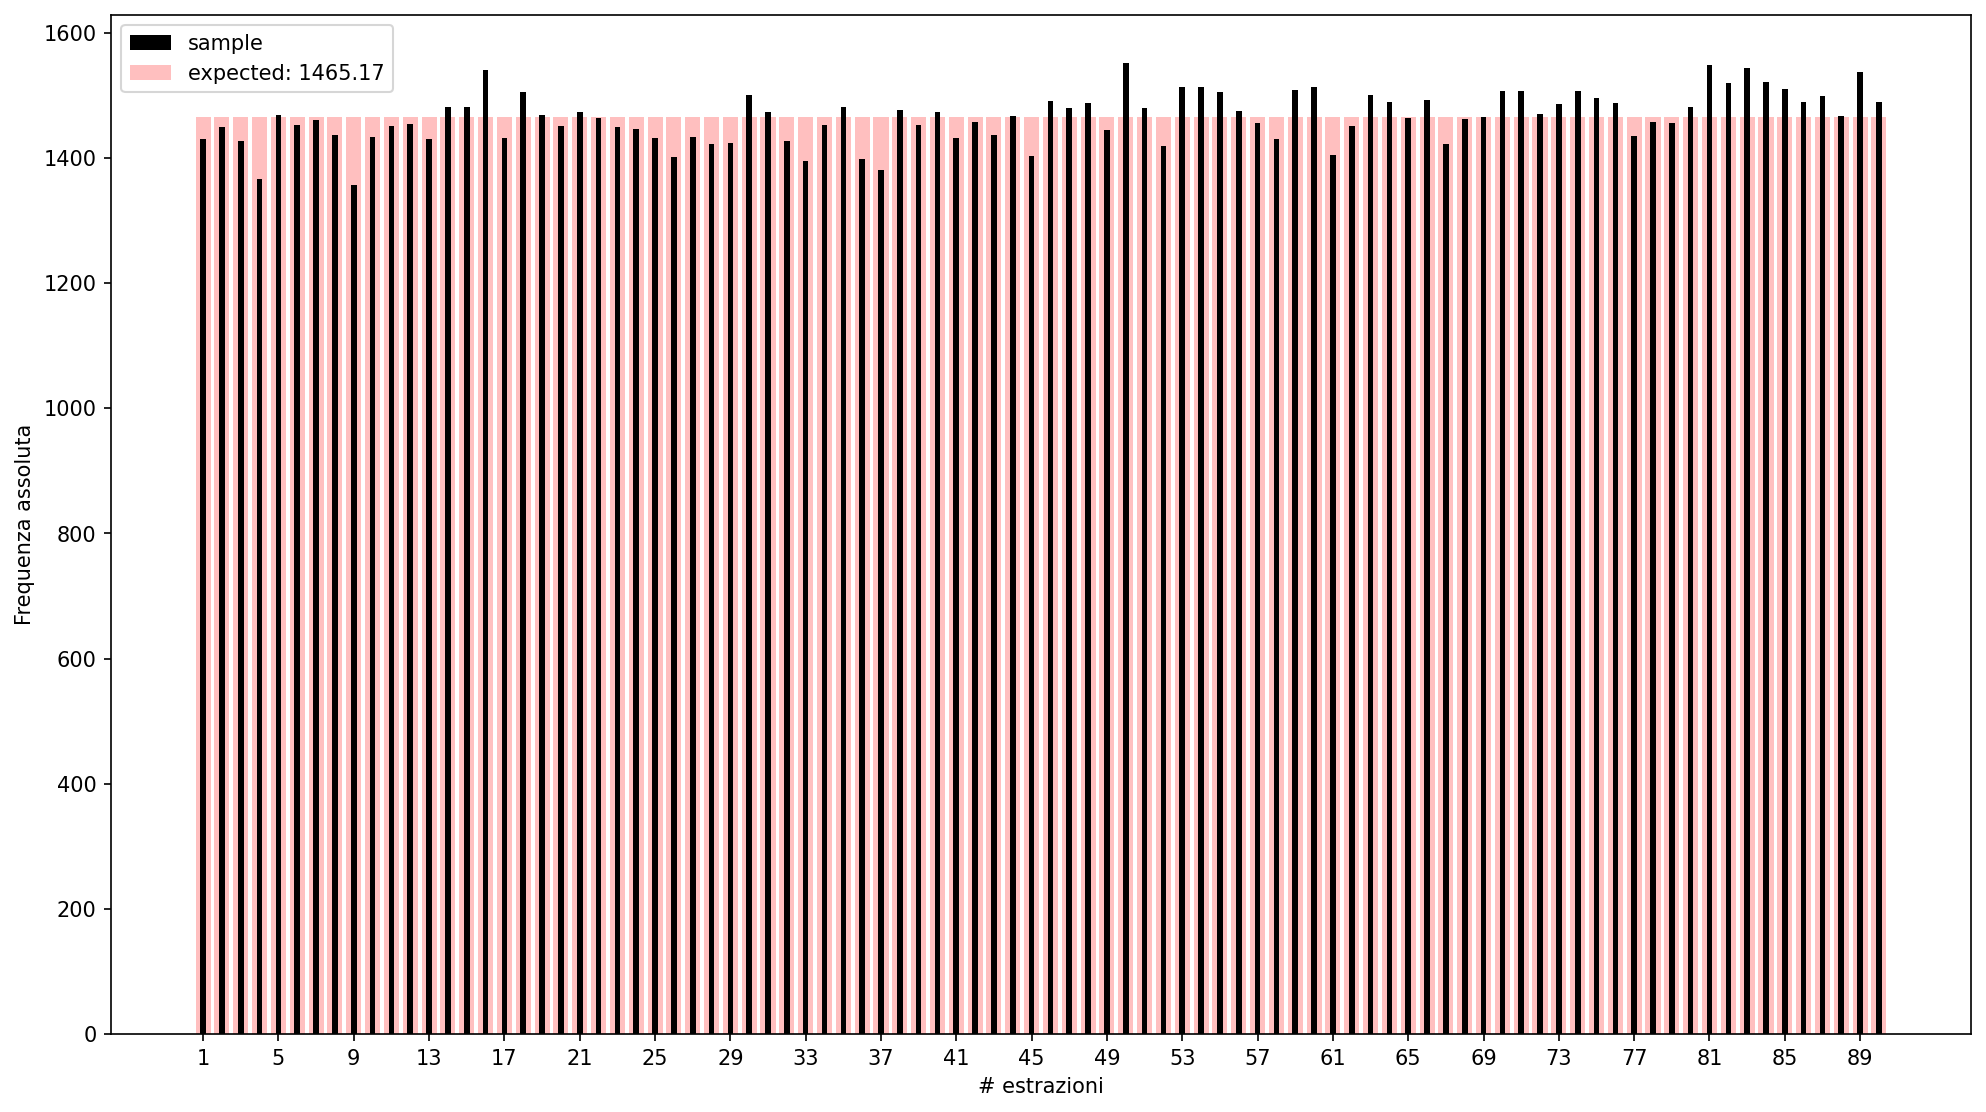

In [280]:
plt.figure(figsize=(16,9),dpi=150)
plt.bar(counts_lotto.index, counts_lotto.values,color='black',zorder=2,width=0.3,label='sample')
plt.bar(unif_counts.index,unif_counts.values,color='red',zorder=1,alpha=0.25,label='expected: {:.2f}'.format(unif_counts.values[0]))
plt.xticks(counts_lotto.index[::4])
plt.legend()
plt.xlabel(r'# estrazioni')
plt.ylabel('Frequenza assoluta')
plt.show()

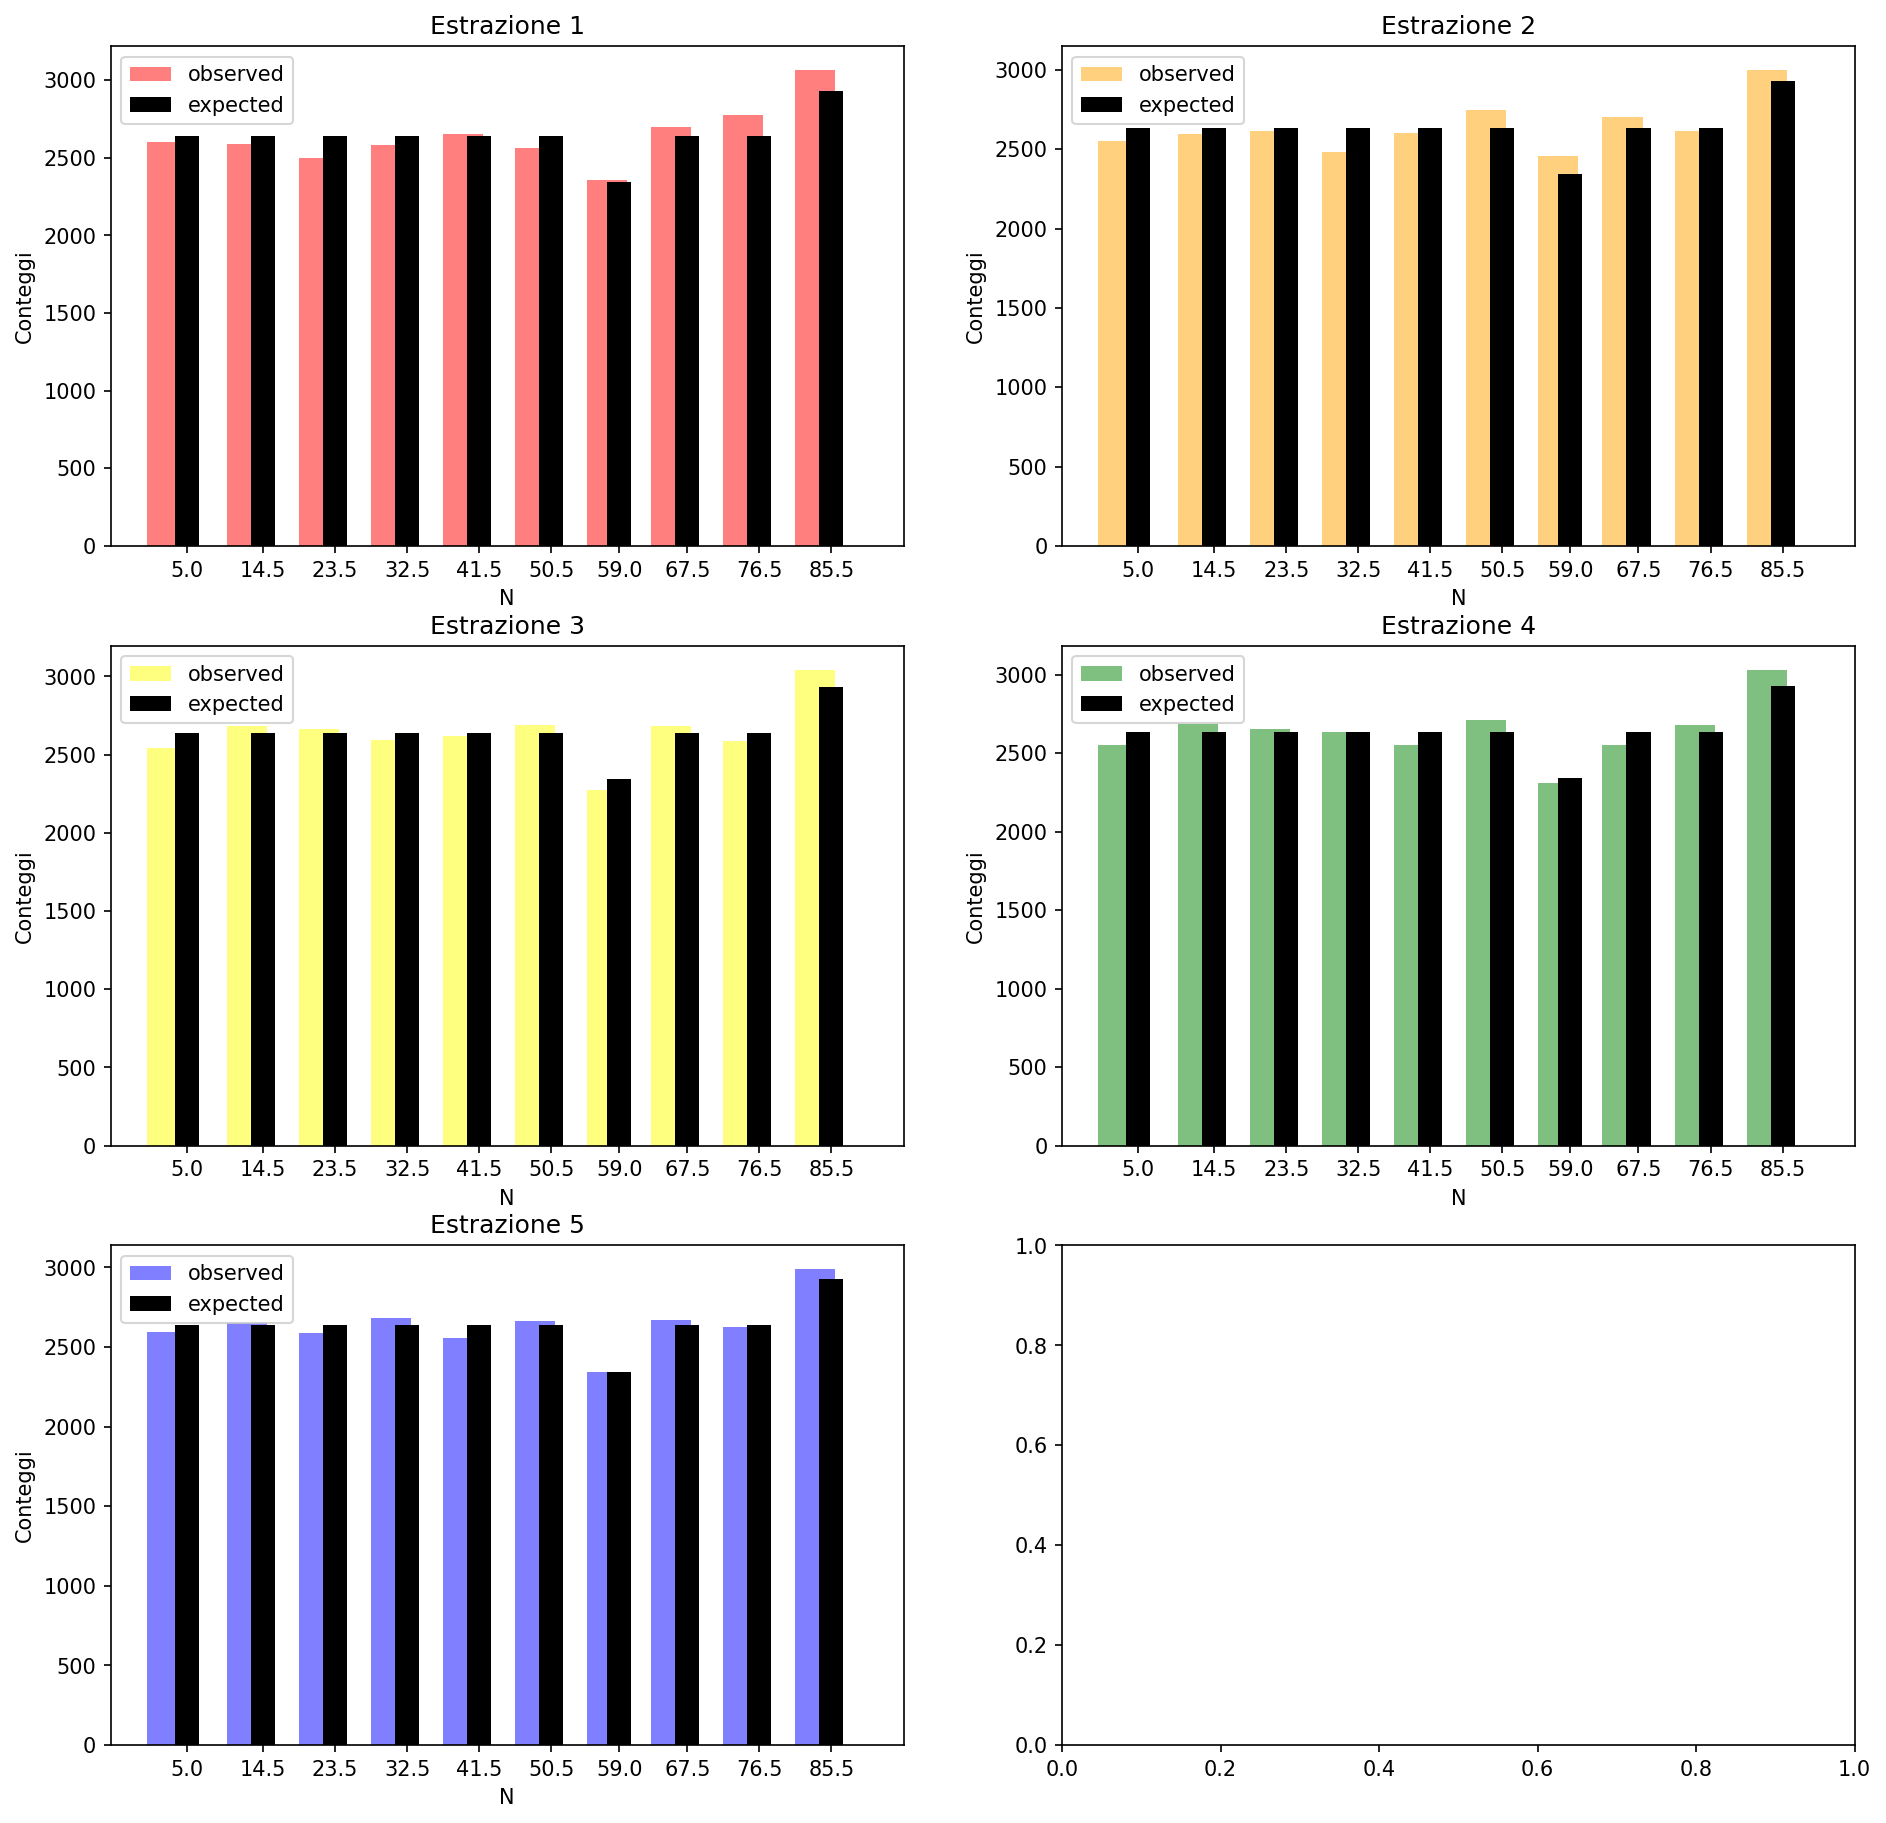

,chi2,p value,Z
1,26.858387,0.001476,2.972646
2,25.970500,0.002066,2.867933
3,14.531652,0.104630,1.255601
4,15.847770,0.070129,1.474828
5,6.811701,0.656717,-0.403519


In [431]:
BIN_n=[0,10,19,28,37,46,55,63,72,81,90]
fig,ax=plt.subplots(3,2,figsize=(15,15),dpi=150)
ax1,ax2,ax3,ax4,ax5,ax6=ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1]
CHI2=[]
counter=0
for numb,color,AX in zip(['1','2','3','4','5'],['r','orange','yellow','green','blue'],[ax1,ax2,ax3,ax4,ax5]):
    c_i,bins_i,patches=AX.hist(lotto89[numb],BIN_n,color=color,width=5,label='observed',alpha=0.5)
    pmfs_i=model.pmf(1)*np.diff(BIN_n)*lotto89[numb].value_counts().sum()
    pmfs_i[0]-=model.pmf(1)*lotto89[numb].value_counts().sum()
    pmfs_i[-1]+=model.pmf(1)*lotto89[numb].value_counts().sum()
    AX.bar(BIN_n[:-1]+np.diff(BIN_n)/2,pmfs_i,color='black',width=3,label='expected')
    AX.legend()
    AX.set_title(r'Estrazione '+numb)
    AX.set_xlabel(r'N')
    AX.set_ylabel('Conteggi')
    AX.set_xticks(BIN_n[:-1]+np.diff(BIN_n)/2)
    res_i2norm=(pmfs_i-c_i)**2/pmfs_i
    chi2_i=res_i2norm.sum()
    CHI2.append(chi2_i)
    counter+=1
plt.show()
dof=len(BIN_n)-2
table_chi2=pd.DataFrame(CHI2, columns=['chi2'],index=range(1,6))
table_chi2['p value']=stats.chi2.sf(np.array(CHI2),dof)
table_chi2['Z']=-stats.norm.ppf(table_chi2['p value'])
table_chi2

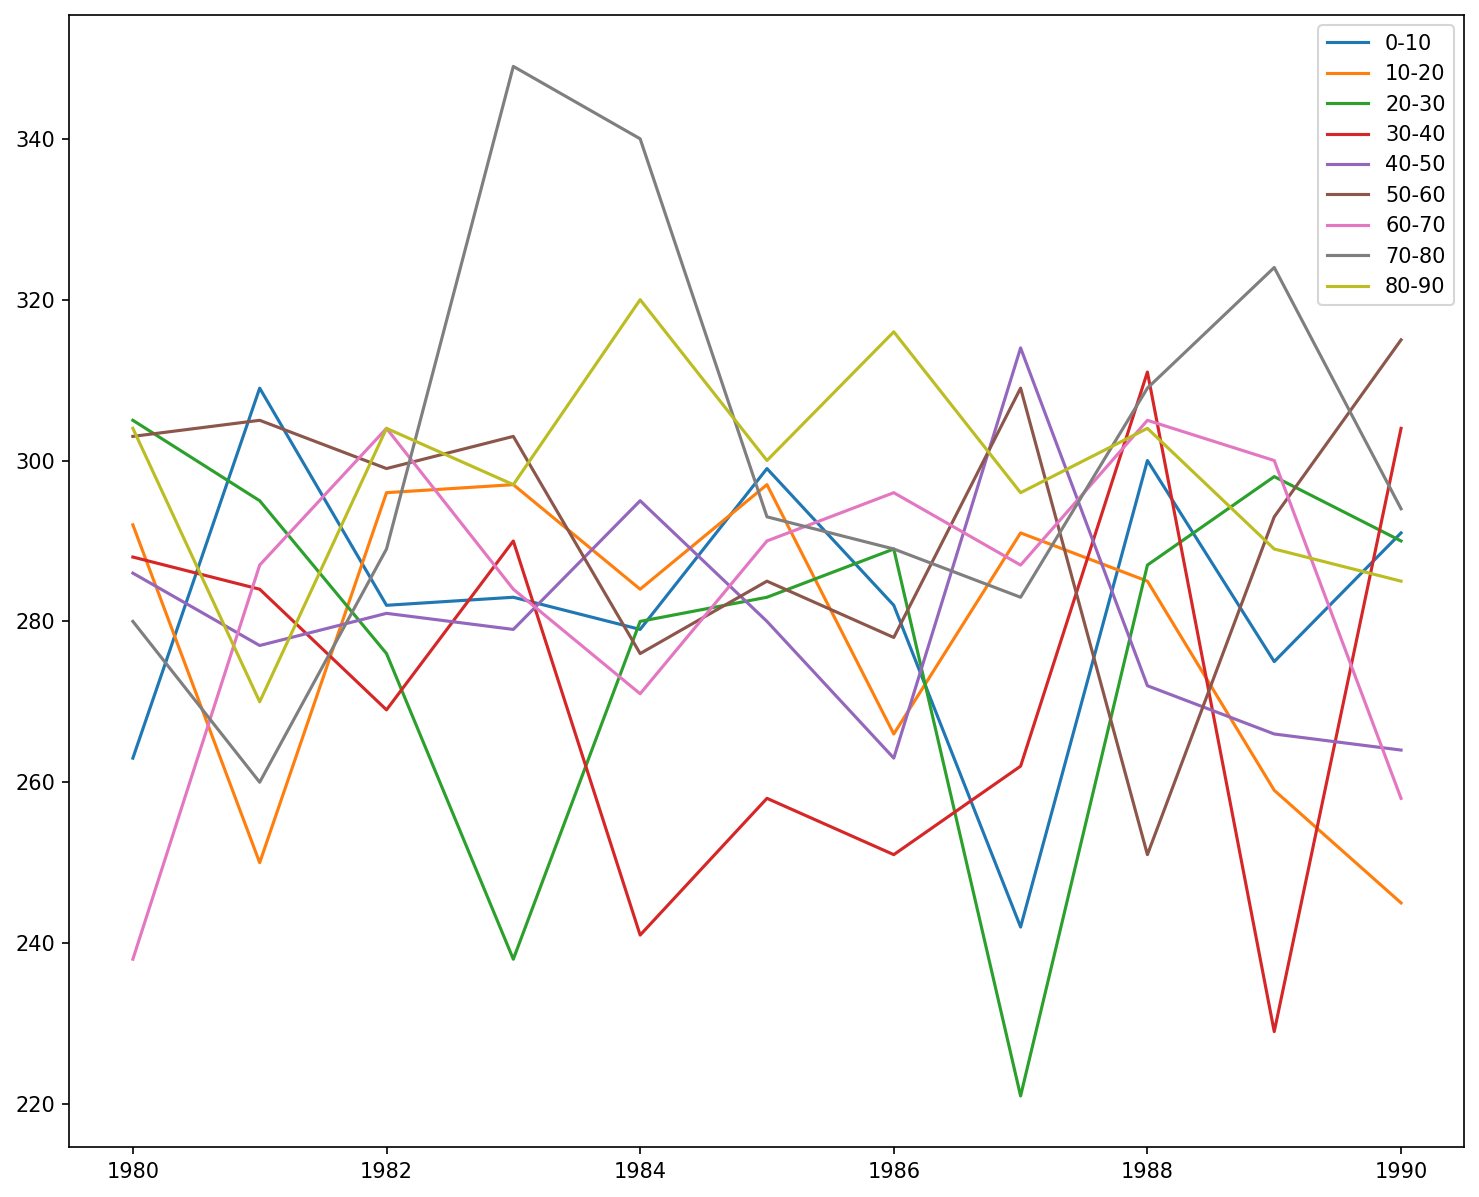

In [450]:
Y1,Y2=1980,1990
lotto_1=lotto[(lotto['dt'].dt.year<=Y2)&(lotto['dt'].dt.year>=Y1)].copy()
lotto_1['Year']=lotto_1['dt'].dt.year
counts_by_year=lotto_1.groupby(by=['Year','1']).size().unstack(level=1)
for num in ['2','3','4','5']:
    counts_by_year=counts_by_year+lotto_1.groupby(by=['Year',num]).size().unstack(level=1)
copy_counts=counts_by_year.copy()
cls=10
for k in np.arange(0,90,cls):
    name=str(k)+'-'+str(k+cls)
    counts_by_year[name]=copy_counts.iloc[:,k:k+cls].sum(axis=1)
cls_by_year=counts_by_year.iloc[:,90:]



plt.figure(figsize=(12,10),dpi=150)
for col in cls_by_year.columns:
    #plt.plot(cls_by_year[col].index,cls_by_year[col].rolling(window=1).mean().shift(-1),label=col)
    plt.plot(cls_by_year[col].index,cls_by_year[col].values,label=col)
    #plt.scatter(cls_by_year[col].index,cls_by_year[col].values)
plt.legend()
plt.show()

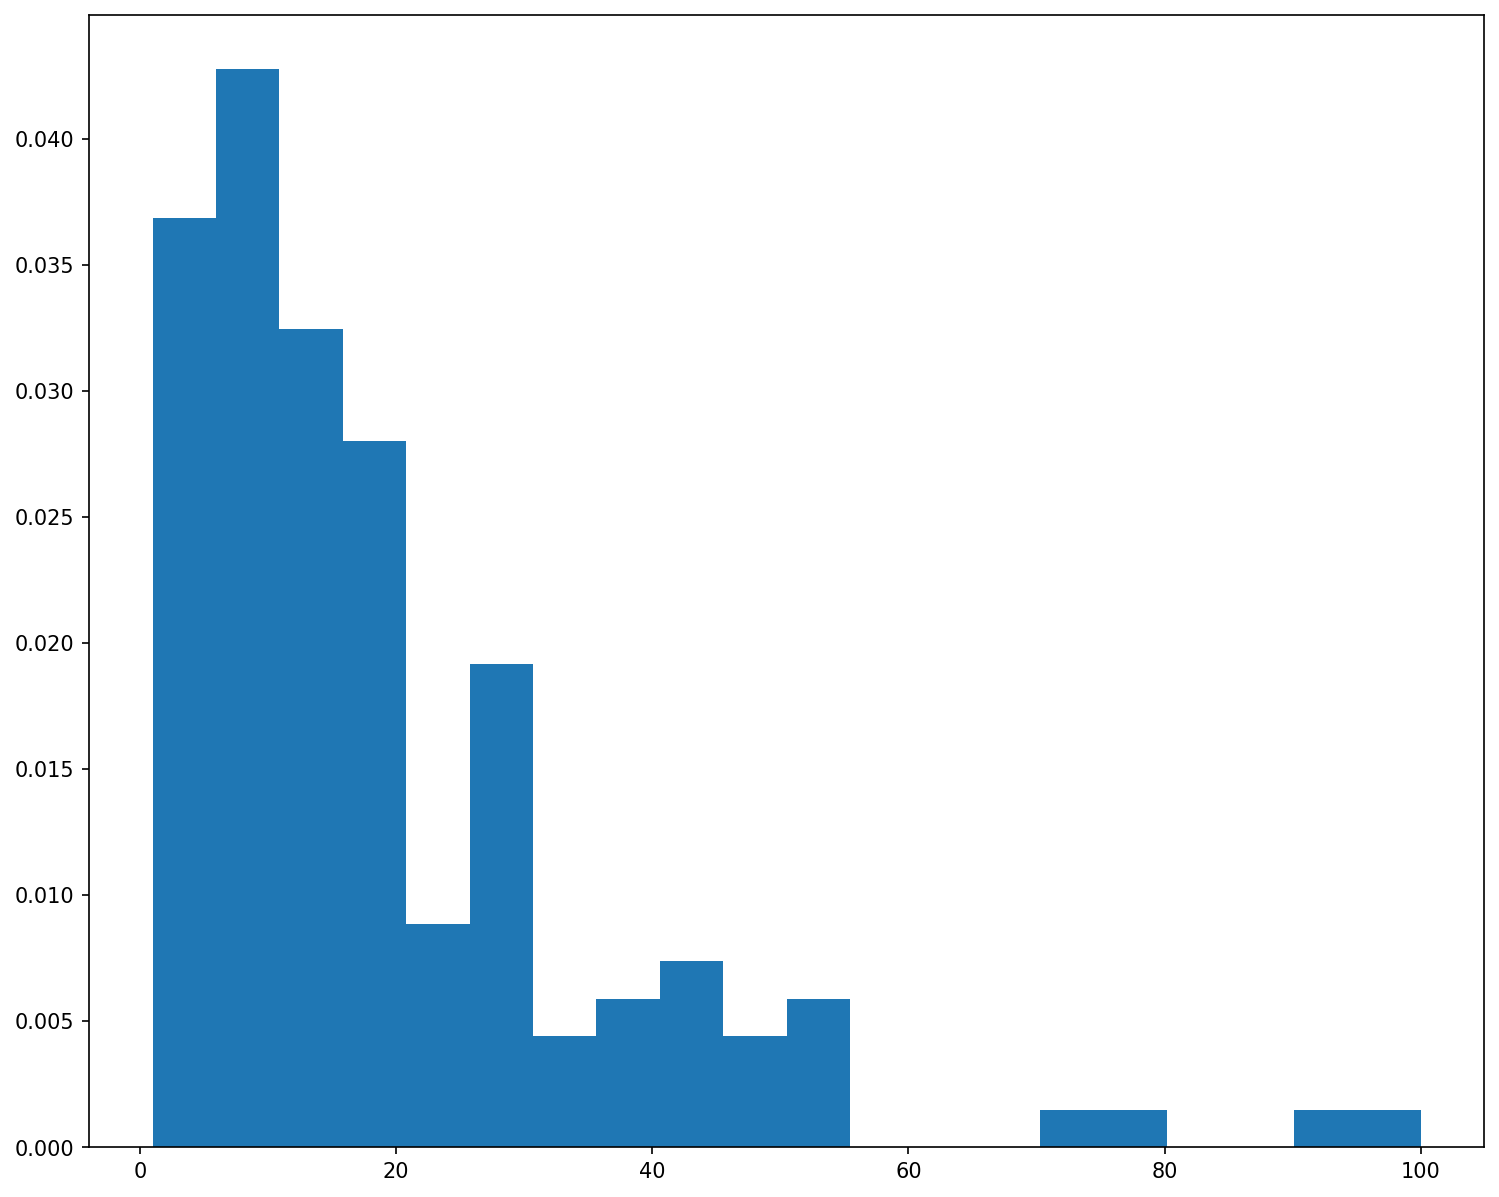

18.985401459854014

In [298]:
numero=85
lottoNA=lotto89[lotto89.city=='NA'].copy()
L_NA=np.array(lottoNA.iloc[:,2:7])
bn=[numero in lNA for lNA in L_NA]
size_ret=len(bn)
c=0
C=[]
for i in range(len(bn)):
    if bn[i]==True:
        f=i-c
        C.append(f)
        c=i
C=np.array(C)
plt.figure(figsize=(12,10),dpi=150)
bin_numb=20
plt.hist(C,bin_numb,density=True)
plt.show()
C.mean()

In [299]:
sample_ret=model.rvs(size_ret)

In [300]:
def estrazioni_senza_rimessa(n,m):
    res=np.empty(m)
    numbers=np.array(range(1,n+1))
    for k in range(m):
        ind=stats.randint.rvs(low=0,high=n-k)
        res[k]=numbers[ind]
        numbers=np.delete(numbers,ind)
    return res
estr_lotto=lambda: estrazioni_senza_rimessa(90,5)
def sample_retards(N):
    sample_ret=np.array([estr_lotto() for k in range(N)])
    bt=[numero in s for s in sample_ret]
    ct=0
    Ct=[]
    for i in range(len(bt)):
        if bt[i]==True:
            ft=i-ct
            Ct.append(ft)
            ct=i
    Ct=np.array(Ct)
    return Ct

In [301]:
N=75000
Ct=sample_retards(N)

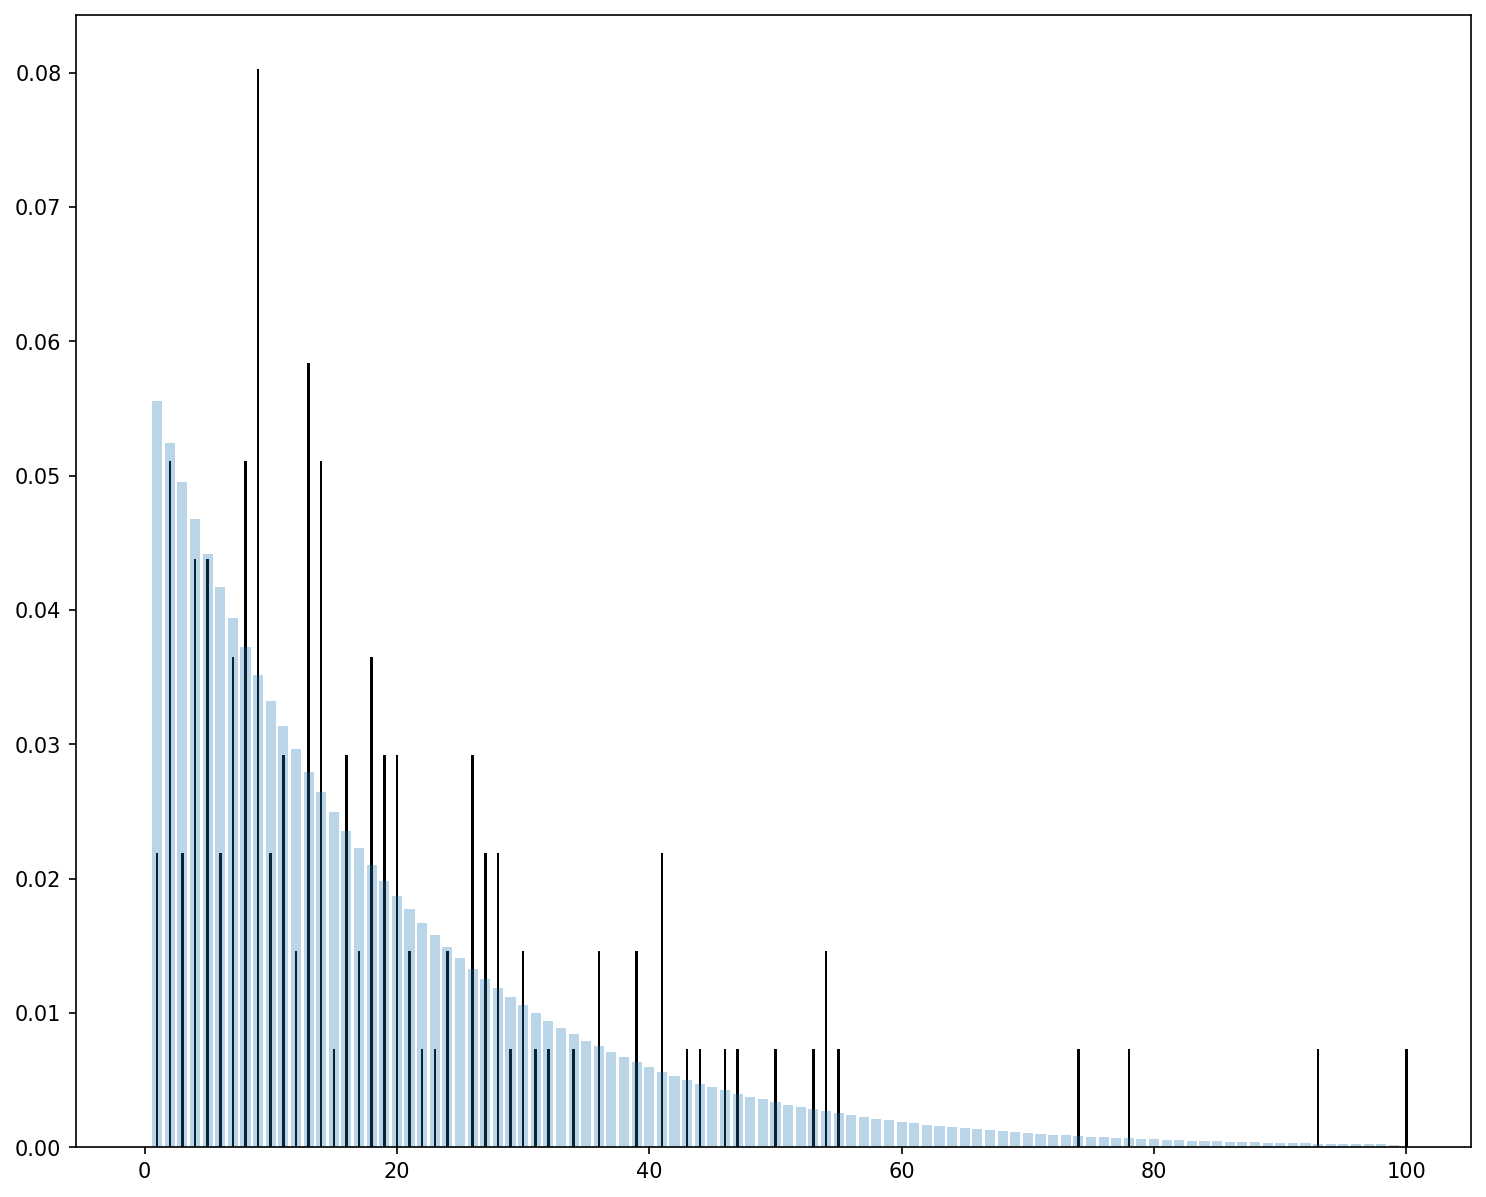

In [308]:
Ct_v,Ct_c=np.unique(Ct,return_counts=True)
C_v,C_c=np.unique(C,return_counts=True)
plt.figure(figsize=(12,10),dpi=150)
#plt.bar(Ct_v,Ct_c/Ct_c.sum(),color='red',alpha=0.5,width=0.5)
plt.bar(C_v,C_c/C_c.sum(),color='black',width=0.2)
th=stats.geom.pmf(np.array(range(0,C.max())),1/18)
plt.bar(np.array(range(0,C.max())),th,alpha=0.3)
plt.show()

In [303]:
Minuit.LIKELIHOOD

0.5

In [304]:
def neglog_lik(mu,samp):
    s=0
    for c in samp:
        s+= -math.log(1/mu)-(c-1)*math.log(1-1/mu)
    return s
nloglik=lambda mu: neglog_lik(mu,samp=C)
nloglik.errordef=Minuit.LIKELIHOOD
mu0=18
m_geom=Minuit(nloglik,(mu0),name=(r'$\mu$',) )
m_geom.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 536.6                      │              Nfcn = 20               │
│ EDM = 1.85e-09 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $\mu$ │   19.0    │    1.6    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────┐
│       │ $\mu$ │
├───────┼───────┤
│ $\mu$ │  2.49 │
└───────┴───────┘

In [305]:
m_geom.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 536.6                      │              Nfcn = 24               │
│ EDM = 1.85e-09 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $\mu$ │   19.0    │    1.6    │    -1.5    │    1.7     │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┐
│          │         $\mu$         │
├──────────┼───────────┬───────────┤
│  Error   │   -1.5    │    1.7    │
│  Valid   │   True    │   True    │
│ At Limit │   False   │   False   │
│ Max FCN  │   False   │   False   │
│ New Min  │   False   │   False   │
└──────────┴───────────┴───────────┘
┌───────┬───────┐
│       │ $\mu$ │
├───────┼───────┤
│ $\mu$ │  2.49 │
└───────┴───────┘

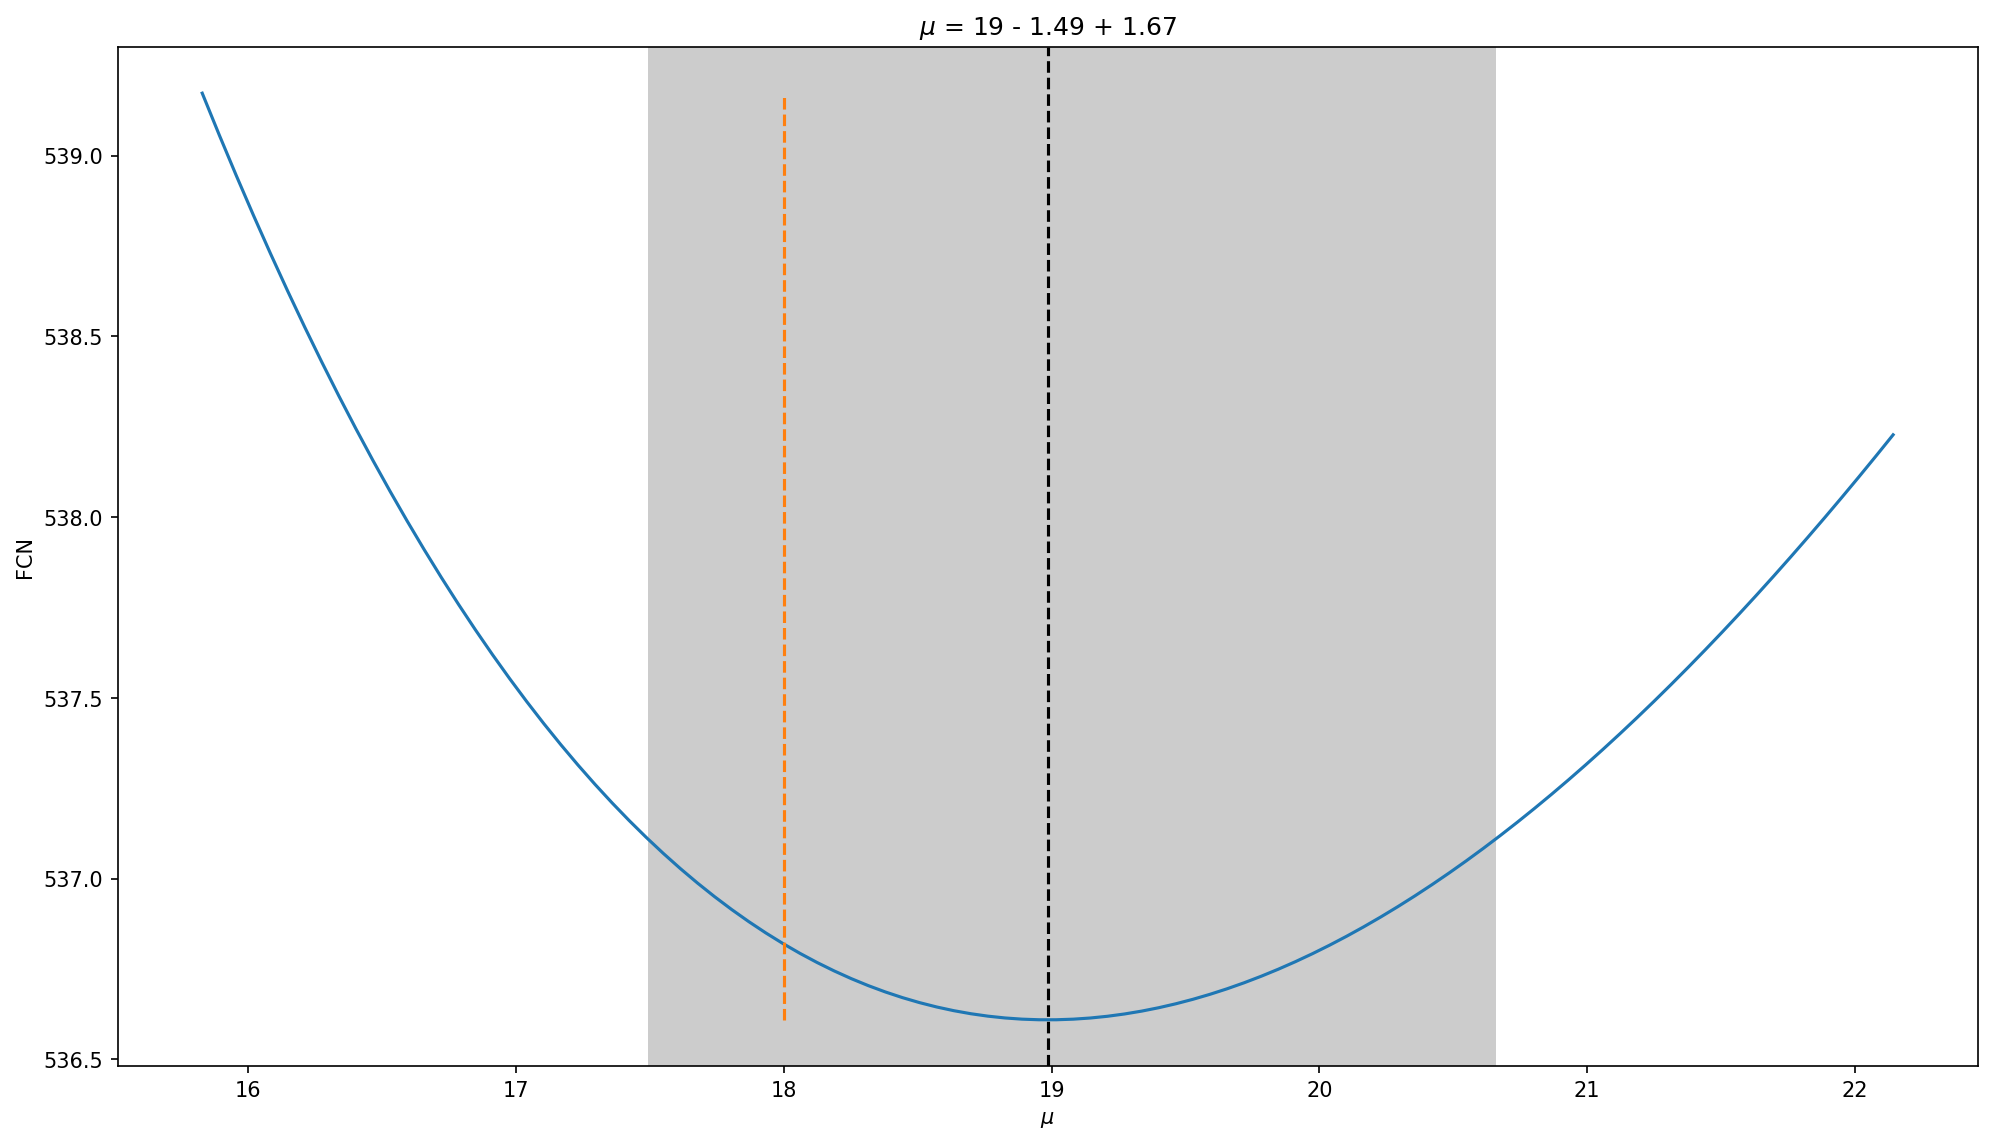

In [306]:
plt.figure(figsize=(16,9), dpi=150)
x,y=m_geom.draw_profile('$\mu$')
plt.plot([18,18],[y.min(),y.max()],linestyle='--')
plt.show()

In [314]:
elotto=pd.read_csv(r'Archivio10eLotto.csv',delimiter=';')
elotto['dt']=pd.to_datetime(elotto['Data'],format="%d/%m/%Y")
elotto89=elotto[elotto['dt'].dt.year<=1989]
superlotto=pd.read_csv(r'ArchivioSuper.csv',delimiter=';', encoding='latin')
superlotto['dt']=pd.to_datetime(superlotto['Data'],format="%d/%m/%Y")
superlotto89=superlotto[superlotto['dt'].dt.year<=1989]

True